In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
import warnings
warnings.filterwarnings('ignore')

# Read the CSV data


# Display basic info about the dataset
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nTarget variable distribution:")
print(df['mortality_30d'].value_counts())

Dataset shape: (13400, 15)

First few rows:
   SUBJECT_ID  HADM_ID            ADMITTIME            DISCHTIME         DOD  \
0       62974   176174  2140-04-17 22:06:00  2140-04-22 15:40:00         NaN   
1        1159   124550  2147-09-25 16:07:00  2147-09-29 18:59:00  2149-11-20   
2       65560   169834  2135-06-12 11:29:00  2135-06-18 15:48:00         NaN   
3       13647   143439  2108-12-17 01:53:00  2108-12-23 13:00:00         NaN   
4       47949   130852  2199-09-21 05:02:00  2199-09-21 12:00:00         NaN   

  GENDER     MARITAL_STATUS INSURANCE ADMISSION_TYPE      RELIGION  \
0      F  UNKNOWN (DEFAULT)   Private      EMERGENCY      CATHOLIC   
1      M  UNKNOWN (DEFAULT)   Private      EMERGENCY      CATHOLIC   
2      F  UNKNOWN (DEFAULT)  Medicare       ELECTIVE  UNOBTAINABLE   
3      M  UNKNOWN (DEFAULT)   Private      EMERGENCY  UNOBTAINABLE   
4      M  UNKNOWN (DEFAULT)  Self Pay      EMERGENCY  UNOBTAINABLE   

               ETHNICITY LANGUAGE  mortality_30d  \
0 


GSN features created: 2407
Procedure features created: 1407
Categorical features created: 42

Total features: 3856
Total samples: 13400

Training set: (10720, 3856)
Test set: (2680, 3856)

5-Fold Cross-Validation ROC-AUC Scores:
Fold 1: 0.8995
Fold 2: 0.9034
Fold 3: 0.8799
Fold 4: 0.8705
Fold 5: 0.8827
Mean CV Score: 0.8872 (+/- 0.0248)


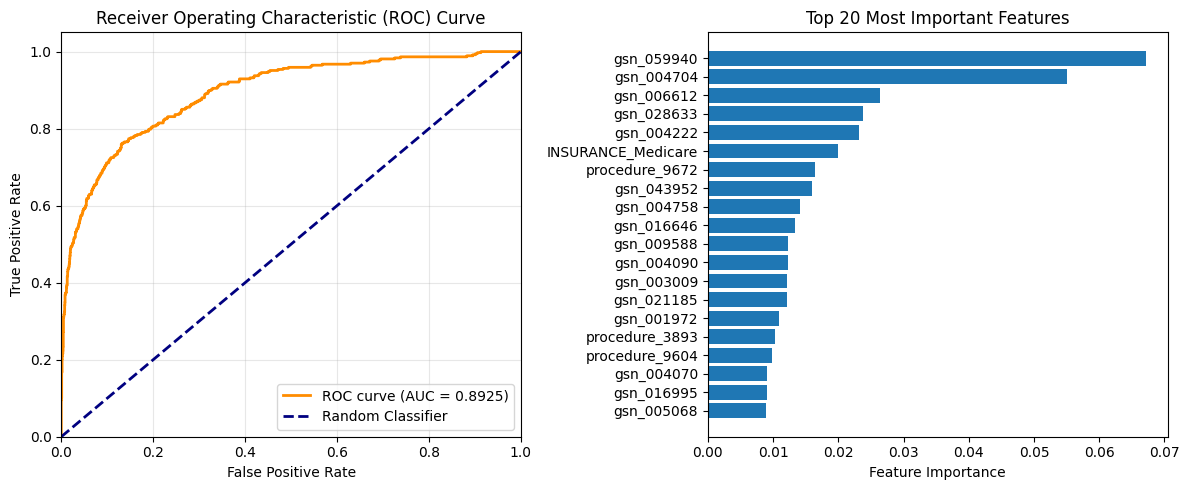


Top 20 Most Important Features:
gsn_059940                               0.067120
gsn_004704                               0.054987
gsn_006612                               0.026448
gsn_028633                               0.023806
gsn_004222                               0.023117
INSURANCE_Medicare                       0.019952
procedure_9672                           0.016488
gsn_043952                               0.015996
gsn_004758                               0.014058
gsn_016646                               0.013337
gsn_009588                               0.012346
gsn_004090                               0.012270
gsn_003009                               0.012096
gsn_021185                               0.012069
gsn_001972                               0.010923
procedure_3893                           0.010225
procedure_9604                           0.009778
gsn_004070                               0.009085
gsn_016995                               0.009060
gsn_005068       

In [ ]:
# Step 1: Prepare the target variable
y = df['mortality_30d']

# Step 2: Multi-label binarization for 'gsn_list' and 'procedure_icd9_list'
def parse_list_column(column):
    """Parse string representation of lists into actual lists"""
    parsed_lists = []
    for item in column:
        try:
            # Handle the string representation of numpy arrays/lists
            if isinstance(item, str):
                # Remove numpy array formatting and convert to list
                clean_item = item.replace("'", "").replace("[", "").replace("]", "").replace("\n", "").strip()
                if clean_item:
                    parsed_list = [x.strip() for x in clean_item.split() if x.strip()]
                else:
                    parsed_list = []
            else:
                parsed_list = []
            parsed_lists.append(parsed_list)
        except:
            parsed_lists.append([])
    return parsed_lists

# Parse the list columns
gsn_lists = parse_list_column(df['gsn_list'])
procedure_lists = parse_list_column(df['procedure_icd9_list'])

# Apply MultiLabelBinarizer
mlb_gsn = MultiLabelBinarizer()
gsn_encoded = mlb_gsn.fit_transform(gsn_lists)
gsn_df = pd.DataFrame(gsn_encoded, columns=[f'gsn_{label}' for label in mlb_gsn.classes_])

mlb_procedure = MultiLabelBinarizer()
procedure_encoded = mlb_procedure.fit_transform(procedure_lists)
procedure_df = pd.DataFrame(procedure_encoded, columns=[f'procedure_{label}' for label in mlb_procedure.classes_])

print(f"\nGSN features created: {gsn_df.shape[1]}")
print(f"Procedure features created: {procedure_df.shape[1]}")

# Step 3: One-hot encoding for categorical columns
categorical_cols = ['GENDER', 'MARITAL_STATUS', 'INSURANCE', 'ADMISSION_TYPE', 'RELIGION', 'ETHNICITY', 'LANGUAGE']

# Handle missing values in categorical columns
df_cat = df[categorical_cols].copy()
for col in categorical_cols:
    df_cat[col] = df_cat[col].fillna('Unknown')

# One-hot encode categorical variables
categorical_encoded = pd.get_dummies(df_cat, columns=categorical_cols, prefix=categorical_cols)

print(f"Categorical features created: {categorical_encoded.shape[1]}")

# Combine all features
X_combined = pd.concat([gsn_df, procedure_df, categorical_encoded], axis=1)

print(f"\nTotal features: {X_combined.shape[1]}")
print(f"Total samples: {X_combined.shape[0]}")

# Step 4: Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

# Step 5: Random Forest with 5-fold Cross Validation
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced'  # Handle class imbalance
)

# 5-fold stratified cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation scores
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=cv, scoring='roc_auc')

print(f"\n5-Fold Cross-Validation ROC-AUC Scores:")
for i, score in enumerate(cv_scores, 1):
    print(f"Fold {i}: {score:.4f}")
print(f"Mean CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Train the final model
rf_model.fit(X_train, y_train)

# Predictions for ROC curve
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

# Step 6: Feature Importance
feature_importance = pd.DataFrame({
    'feature': X_combined.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 20 most important features
plt.subplot(1, 2, 2)
top_features = feature_importance.head(20)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 20 Most Important Features')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

# Display feature importance table
print(f"\nTop 20 Most Important Features:")
print("="*50)
for idx, row in feature_importance.head(20).iterrows():
    print(f"{row['feature']:<40} {row['importance']:.6f}")

# Model performance summary
test_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\n" + "="*50)
print("MODEL PERFORMANCE SUMMARY")
print("="*50)
print(f"Cross-Validation Mean AUC: {cv_scores.mean():.4f}")
print(f"Cross-Validation Std: {cv_scores.std():.4f}")
print(f"Test Set AUC: {test_auc:.4f}")
print(f"Total Features Used: {X_combined.shape[1]}")
print(f"GSN Features: {gsn_df.shape[1]}")
print(f"Procedure Features: {procedure_df.shape[1]}")
print(f"Categorical Features: {categorical_encoded.shape[1]}")

# Additional model information
y_pred = rf_model.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix

print(f"\nClassification Report:")
print(classification_report(y_test, y_pred))

print(f"\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Feature importance statistics
print(f"\nFeature Importance Statistics:")
print(f"Mean importance: {feature_importance['importance'].mean():.6f}")
print(f"Std importance: {feature_importance['importance'].std():.6f}")
print(f"Max importance: {feature_importance['importance'].max():.6f}")
print(f"Features with importance > 0.01: {(feature_importance['importance'] > 0.01).sum()}")